In [2]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import os
import random
from tqdm import tqdm
from PIL import Image
import math
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2

In [3]:
# Save checkpoint
def save_checkpoint(state,filename='weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(filename,model,optim):
    print('Loading weights-->')
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

In [4]:
# We need to generate 1 single mask from all masks
# First we retrieve all masks associated with current image
                                          
def generate_image_from_masks(mask,original_image):
    custom_colors = np.array([
    [0, 0, 0],
    [0, 153, 255],
    [102, 255, 153],
    [0, 204, 153],
    [255, 255, 102],
    [255, 255, 204],
    [255, 153, 0],
    [255, 102, 255],
    [102, 0, 51],
    [255, 204, 255],
    [255, 0, 102]])
    h, w = mask.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            class_value = mask[y, x]
            rgb_image[y, x] = custom_colors[class_value]
    return rgb_image

def normalise_image(image): # not used currently, lets add based on performance
    # perform mean and std deviation normalization
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

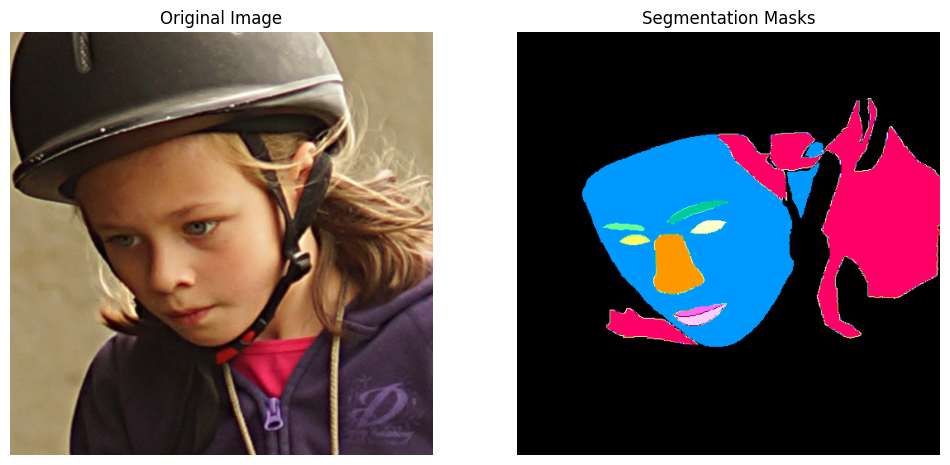

In [5]:
# Data Visualization
image_path = "/kaggle/input/lapa-face-parsing-dataset/LaPa/train/images/10001436895_0.jpg"
mask_path = "/kaggle/input/lapa-face-parsing-dataset/LaPa/train/labels/10001436895_0.png"
    
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
mask_img = cv2.resize(mask_img, (512, 512))
mask_img = generate_image_from_masks(mask_img,image_rgb)

# Display original and mask images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
axes[0].imshow(image_rgb)  # Display original image
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axis
axes[1].imshow(mask_img)  # Display composite image with masks
axes[1].set_title('Segmentation Masks')
axes[1].axis('off')  # Hide axis
plt.show()

In [6]:
class Lapa(Dataset):
    def __init__(self,images_dir,masks_dir,transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_files = os.listdir(images_dir)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = img_path.replace("images","labels").replace("jpg","png")
        # Open image
        image = Image.open(img_path)
        # Open masks - create 1 mask or N masks???? N mask for ground truth and N masks from CNN seems like a better design choice
        mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask_img = cv2.resize(mask_img, (512, 512))
        # Split the masks
        binary_masks = []

        # Iterate over each class
        for class_value in range(0, 11):
            # Create a binary mask for the current class
            binary_mask = (mask_img == class_value).astype(np.float32)
            binary_masks.append(binary_mask)
        # convert to tensor
        torch_tensors_list = [torch.tensor(mask) for mask in binary_masks]
        return self.transform(image), torch.stack(torch_tensors_list, dim=0)

In [7]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the image
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Define the Transform Customly - as when we do random flips on img, these flips should happen on mask as well
class CustomTransform():
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        # Resize
        image = transforms.functional.resize(image,[512,512])
        # Random horizontal and vertical flipping
        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        if random.random() > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)
        # Convert PIL images to PyTorch tensors
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        return image,mask

In [9]:
# Define segmentation architectures
class VanillaUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(VanillaUNet, self).__init__()
        # Encode architecture
        self.dconv1 = self._double_conv(in_channels, 64)
        self.dconv2 = self._double_conv(64, 128)
        self.dconv3 = self._double_conv(128, 256)
        self.dconv4 = self._double_conv(256, 512)
        self.dconv5 = self._double_conv(512, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512,256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256,128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128,64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def _double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv
    
    def forward(self,X):
        # Forward Prop thru Encoder 
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dconv1(X)              # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.max_pool(X1)           # X2 Shape : [B X 64 X 256 X 256]
        
        X3 = self.dconv2(X2)             # X3 Shape : [B X 128 X 256 X 256]
        X4 = self.max_pool(X3)           # X4 Shape : [B X 128 X 128 X 128]
        
        X5 = self.dconv3(X4)             # X5 Shape : [B X 256 X 128 X 128]
        X6 = self.max_pool(X5)           # X6 Shape : [B X 256 X 64 X 64]
        
        X7 = self.dconv4(X6)             # X7 Shape : [B X 512 X 64 X 64]
        X8 = self.max_pool(X7)           # X8 Shape : [B X 512 X 32 X 32]
        
        X9 = self.dconv5(X8)             # X9 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X10 = self.uconv1(X9)            # X10 Shape : [B X 512 X 64 X 64]
        X11 = torch.cat((X10,X7),dim=1)  # X11 Shape : [B X 1024 X 64 X 64]
        X12 = self.dconv6(X11)           # X12 Shape : [B X 512 X 64 X 64]
        
        X13 = self.uconv2(X12)           # X13 Shape : [B X 256 X 128 X 128]
        X14 = torch.cat((X13,X5),dim=1)  # X14 Shape : [B X 512 X 128 X 128]
        X15 = self.dconv7(X14)           # X15 Shape : [B X 256 X 128 X 128]
        
        X16 = self.uconv3(X15)            # X16 Shape : [B X 128 X 256 X 256]
        X17 = torch.cat((X16,X3),dim=1)   # X17 Shape : [B X 256 X 256 X 256]
        X18 = self.dconv8(X17)            # X18 Shape : [B X 128 X 256 X 256]
        
        X19 = self.uconv4(X18)            # X19 Shape : [B X 64 X 512 X 512]
        X20 = torch.cat((X19,X1),dim=1)   # X20 Shape : [B X 128 X 512 X 512]
        X21 = self.dconv9(X20)            # X21 Shape : [B X 64 X 512 X 512]
        
        # Final Conv Layer
        X22 = self.final_conv(X21)        # X22 Shape : [B X num_classes X 512 X 512]
        
        return F.softmax(X22,dim=1)

In [10]:
# Create datasets
train_dataset = Lapa("/kaggle/input/lapa-face-parsing-dataset/LaPa/train/images",
                    "/kaggle/input/lapa-face-parsing-dataset/LaPa/train/labels",
                    transform)

val_dataset = Lapa("/kaggle/input/lapa-face-parsing-dataset/LaPa/val/images",
                    "/kaggle/input/lapa-face-parsing-dataset/LaPa/val/labels",
                    transform)

In [22]:
# Params
learning_rate = 0.001
num_epochs = 5
num_workers = 2
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Instantiate model
model = VanillaUNet(in_channels=3,num_classes=11)

In [25]:
# Define Criterion, Loss function, LR Scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

In [26]:
x,y = next(iter(train_loader))
print(x.shape,y.shape)
# ignore warnings - some images do not have all 10 segment masks

torch.Size([4, 3, 512, 512]) torch.Size([4, 11, 512, 512])


In [27]:
model.to(device)
x = x.to(device)
y = y.to(device)
print()

In [28]:
print(y[2].unique())

tensor([0., 1.], device='cuda:0')


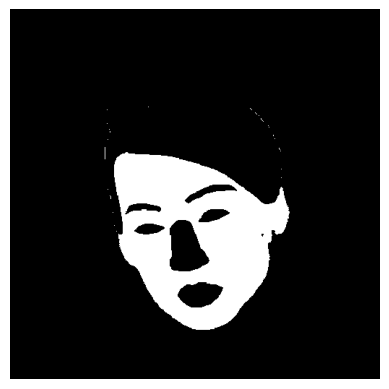

In [29]:
# sample mask
image_tensor = y[2][1]
image_array = image_tensor.cpu().numpy()

# Display the grayscale image using Matplotlib
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

In [30]:
y_pred = model(x)
print(y_pred.shape,y.shape)

torch.Size([4, 11, 512, 512]) torch.Size([4, 11, 512, 512])


In [31]:
def train_loop(model,dataloader,loss_fun,optimizer,device):
    model.train()
    model.to(device)
    min_loss = None
    for epoch in range(num_epochs):
        losses = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)
    
            # forward pass
            y_pred = model(x)
            
            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())
            
            # zero out prior gradients
            optimizer.zero_grad()
            
            # backprop
            loss.backward()
            
            # update weights
            optimizer.step()
            scheduler.step()
            
            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item())

        moving_loss = sum(losses) / len(losses)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1}'.format(epoch, moving_loss))

In [ ]:
train_loop(model,train_loader,criterion,optimizer,device)

Epoch [0/5] : 100%|██████████| 4542/4542 [41:11<00:00,  1.84it/s, loss=0.674]


Saving weights-->
Epoch 0 : Loss = 0.6762478073123057


Epoch [1/5] : 100%|██████████| 4542/4542 [41:20<00:00,  1.83it/s, loss=0.664]


Saving weights-->
Epoch 1 : Loss = 0.6687390425036207


Epoch [2/5] : 100%|██████████| 4542/4542 [41:17<00:00,  1.83it/s, loss=0.664]


Saving weights-->
Epoch 2 : Loss = 0.6663208830755537


Epoch [3/5] : 100%|██████████| 4542/4542 [41:15<00:00,  1.83it/s, loss=0.665]


Saving weights-->
Epoch 3 : Loss = 0.665430497343663


Epoch [4/5] :  82%|████████▏ | 3733/4542 [33:59<07:20,  1.84it/s, loss=0.662]

In [ ]:
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x,y)
            
            # caclulate test loss
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())
            
            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

In [ ]:
test_loop(model,va_loader,criterion,device)